In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
def load_images(path):
    classes = os.listdir(path)
    df = pd.DataFrame()
    
    for cls in classes:
        cls_path = os.path.join(path, cls)
        
        if not os.path.isdir(cls_path):
            continue
        
        for file in os.listdir(cls_path):
            image_path = os.path.join(path, cls, file)
            
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                image = np.asarray(image, dtype=np.double)
                image /= np.linalg.norm(image)
                df = df.append(pd.Series({'emotion': cls, 'image': image}), ignore_index=True)
    
    return df
    
df_train = load_images('data/train')

/var/folders/3j/_8ty5xgj2md7zt6kftlz05hmf593br/T/ipykernel_3116/2035053682.py:17: RuntimeWarning: invalid value encountered in true_divide
  image /= np.linalg.norm(image)


In [4]:
df_train.shape

(28709, 2)

In [73]:
df_train['emotion'].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: emotion, dtype: int64

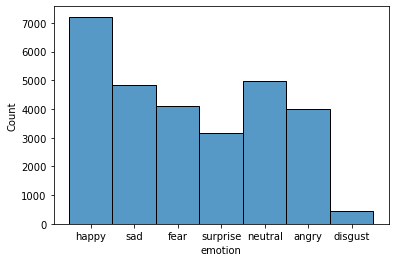

In [74]:
sns.histplot(df_train['emotion']);

In [1]:
df_train.head()

NameError: name 'df_train' is not defined